# Deep Q-Network in cartpole
We are going to use a DQN for cartpole

In [1]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tnrange, tqdm_notebook
import numpy as np
from collections import deque

%matplotlib inline

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

Next we create the environment

In [2]:
import gym
env = gym.make("CartPole-v0").env

[2017-10-20 14:42:33,566] Making new env: CartPole-v0


Next we will create the usual hidden layer (with saved params to copy the NN). I will try to substitute it with a dense layer from TF

In [3]:
import tensorflow as tf
from dqn_tf import *
'''
class HiddenLayer:
    
    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
            self.params.append(self.b)
        self.f = f
    
    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)
'''

'\nclass HiddenLayer:\n    \n    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):\n        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))\n        self.params = [self.W]\n        self.use_bias = use_bias\n        if use_bias:\n            self.b = tf.Variable(np.zeros(M2).astype(np.float32))\n            self.params.append(self.b)\n        self.f = f\n    \n    def forward(self, X):\n        if self.use_bias:\n            a = tf.matmul(X, self.W) + self.b\n        else:\n            a = tf.matmul(X, self.W)\n        return self.f(a)\n'

Next we will create di DQN model

Now we will define the function to play one episode

In [4]:
'''
class DQN:
    
    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_size=32):
    
        self.K = K
        # Create hidden layers
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
        # Final layer with linear f
        layer = HiddenLayer(M2, K, lambda x: x)
        self.layers.append(layer)
        # Save params
        self.params = []
        for layer in self.layers:
            self.params += layer.params
        # Placeholder for input and target
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.G = tf.placeholder(tf.float32, shape=(None,), name='G')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')
        # Forwarding
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = Z
        self.predict_op = Y_hat
        # Cost
        selected_action_values = tf.reduce_sum(Y_hat * tf.one_hot(self.actions, K), reduction_indices=[1])
        cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
        self.train_op = tf.train.AdagradOptimizer(10e-3).minimize(cost)
        # Replay memory
        self.experience = {'s' : [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.batch_size = batch_size
        self.gamma = gamma
        
    def set_session(self, session):
        self.session = session
        
    def copy_from(self, other):
        ops = []
        my_params = self.params
        other_params = other.params
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)
        self.session.run(ops)
    
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X : X})
    
    def train(self, target_network):
        # First check we have min experiences
        if len(self.experience['s']) < self.min_experiences:
            return
        # If we have min exp, we can proceed. Select a batch of indexes
        idx = np.random.choice(len(self.experience['s']), size=self.batch_size, replace=False)
        states = [self.experience['s'][i] for i in idx]
        actions = [self.experience['a'][i] for i in idx]
        rewards = [self.experience['r'][i] for i in idx]
        next_states = [self.experience['s2'][i] for i in idx]
        dones = [self.experience['done'][i] for i in idx]
        # Calculate targets
        next_Q = np.max(target_network.predict(next_states), axis=1)
        targets = [r + self.gamma * next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]
        # Train
        self.session.run(self.train_op, feed_dict={
            self.X: states,
            self.G: targets,
            self.actions: actions
        })
        
    def add_experience(self, s, a, r, s2, done):
        if len(self.experience['s']) >= self.max_experiences:
            self.experience['s'].pop(0)
            self.experience['a'].pop(0)
            self.experience['r'].pop(0)
            self.experience['s2'].pop(0)
            self.experience['done'].pop(0)
        self.experience['s'].append(s)
        self.experience['a'].append(a)
        self.experience['r'].append(r)
        self.experience['s2'].append(s2)
        self.experience['done'].append(done)
        
    def sample_action(self, X, eps):
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            X = np.atleast_2d(X)
        return np.argmax(self.predict(X)[0])
'''

"\nclass DQN:\n    \n    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_size=32):\n    \n        self.K = K\n        # Create hidden layers\n        self.layers = []\n        M1 = D\n        for M2 in hidden_layer_sizes:\n            layer = HiddenLayer(M1, M2)\n            self.layers.append(layer)\n            M1 = M2\n        # Final layer with linear f\n        layer = HiddenLayer(M2, K, lambda x: x)\n        self.layers.append(layer)\n        #\xa0Save params\n        self.params = []\n        for layer in self.layers:\n            self.params += layer.params\n        #\xa0Placeholder for input and target\n        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')\n        self.G = tf.placeholder(tf.float32, shape=(None,), name='G')\n        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')\n        # Forwarding\n        Z = self.X\n        for layer in self.layers:\n            Z = layer.forwa

In [5]:
'''
def play_one(env, model, tmodel, eps, gamma, copy_period, render=False):
    observation = env.reset()
    done = False
    i = 0
    frames = []
    totalreward = 0
    while not done and i < 2000:
        if render:
            frames.append(env.render(mode = 'rgb_array'))
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, _ = env.step(action)
        totalreward += reward
        if done:
            reward = -200
        # Add experience
        model.add_experience(prev_observation, action, reward, observation, done)
        model.train(tmodel)
        # Increase index and check if copy
        i += 1
        if i % copy_period == 0:
            tmodel.copy_from(model)
    return totalreward, frames
'''

"\ndef play_one(env, model, tmodel, eps, gamma, copy_period, render=False):\n    observation = env.reset()\n    done = False\n    i = 0\n    frames = []\n    totalreward = 0\n    while not done and i < 2000:\n        if render:\n            frames.append(env.render(mode = 'rgb_array'))\n        action = model.sample_action(observation, eps)\n        prev_observation = observation\n        observation, reward, done, _ = env.step(action)\n        totalreward += reward\n        if done:\n            reward = -200\n        # Add experience\n        model.add_experience(prev_observation, action, reward, observation, done)\n        model.train(tmodel)\n        # Increase index and check if copy\n        i += 1\n        if i % copy_period == 0:\n            tmodel.copy_from(model)\n    return totalreward, frames\n"

Next we will init and start

episode: 0 total reward: 19.0 eps: 1.0 avg reward (last 100): 19.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 19.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 32.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 44.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 54.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 66.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 76.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 86.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 96.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 104.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 117.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 129.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 161.0
avg reward for last 100 episodes: 6.01801588995e-31
total steps: 176.0
avg reward for las

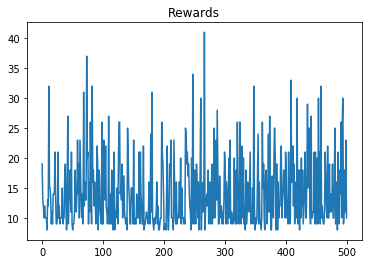

In [6]:
gamma = 0.99
copy_period = 50

D = len(env.observation_space.sample())
K = env.action_space.n
sizes = [200,200]
model = DQN(D, K, sizes, gamma)
tmodel = DQN(D, K, sizes, gamma)
init = tf.global_variables_initializer()
session = tf.InteractiveSession()
session.run(init)
model.set_session(session)
tmodel.set_session(session)

N = 500
totalrewards = np.empty(N)
costs = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, tmodel, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()